In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.io import loadmat
from scipy.signal import hilbert
from random import randint, shuffle
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from cv2 import merge
print(tf.__version__)

2.0.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/'My Drive'/BME590_Machine_Learning

/content/drive/My Drive/BME590_Machine_Learning


In [0]:
data = loadmat('OASBUD.mat')['data'][0] # mat file is dict with header, we just want the data key (which is stored as a list of lists)
# each of the 100 data points consists of 7 arrays
# array 0: patient's unique ID
# array 1: first scan plane (first set of rf dta)
# array 2: second scan plane (second set of rf data)
# array 3: region of interest for first scan plane
# array 4: region of interest for second scan plane
# array 5: BI-RADS category (low, medium, high probability of malignancy)
# array 6: label (0 = benign, 1 = malignant)

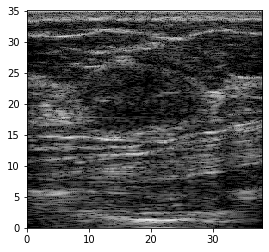

In [0]:
# example image processing of first data point:
c = 1540
width = 38
fs = 40e6
rf1 = data[0][1]
roi1 = data[0][3]

def preprocessing(rf_data, db_threshold):
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))
    envelope_image[envelope_image < -1.0*db_threshold] = -1.0*db_threshold
    return 255.0*(envelope_image + db_threshold)/(db_threshold)    
    
plt.imshow(preprocessing(rf1,50),extent=[0,width,0,rf1.shape[0]*500*c/fs],cmap='gray')
plt.show()

In [0]:
# to get data and labels for all scans
dB_cutoff=50
labeled_data = []
for n in range(len(data)):
  labeled_data.append((preprocessing(data[n][1],dB_cutoff), data[n][3])) # data for scan 1, roi for scan 1
  labeled_data.append((preprocessing(data[n][2],dB_cutoff), data[n][4])) # data for scan 2, roi for scan 2

In [0]:
# Randomly crop images so that a certain percentage of the cropped image is the lesion
def augment_data(labeled_data):
  augmented_labeled_data = []
  crop_size = 224
  for data in labeled_data:
    count = 0
    lower_perc = 0.3
    upper_perc = 0.7
    while count < 8:
      # For each image in labeled_data, obtain 8 random cropped images 
      # that contain at least lower_perc and at most upper_perc lesion of the total image
      num_bad = 1
      start_x = randint(0, np.size(data[0], 0) - crop_size)
      start_y = randint(0, np.size(data[0], 1) - crop_size)
      new_roi = data[1][start_x:start_x+crop_size, start_y:start_y+crop_size]
      num_ones = np.count_nonzero(new_roi == 1)
      # Keep randomly cropping so long as new_im doesn't meet constraints
      while not ((crop_size**2)*lower_perc < num_ones < (crop_size**2)*upper_perc):
        start_x = randint(0, np.size(data[0], 0) - crop_size)
        start_y = randint(0, np.size(data[0], 1) - crop_size)
        new_roi = data[1][start_x:start_x+crop_size, start_y:start_y+crop_size]
        num_ones = np.count_nonzero(new_roi == 1)
        num_bad = num_bad + 1
        # if failed to find images with those percentage constraints, loosen the constraints
        if num_bad%15 == 0:
          lower_perc = lower_perc/1.5
      count = count + 1
      new_im = data[0][start_x:start_x+crop_size, start_y:start_y+crop_size] / 255.0
      new_roi = data[1][start_x:start_x+crop_size, start_y:start_y+crop_size]
      augmented_labeled_data.append((merge((new_im, new_im, new_im)), new_roi))
      augmented_labeled_data.append((merge((np.fliplr(new_im), np.fliplr(new_im), np.fliplr(new_im))), np.fliplr(new_roi)))
      augmented_labeled_data.append((merge((np.flipud(new_im), np.flipud(new_im), np.flipud(new_im))), np.flipud(new_roi)))
  return augmented_labeled_data

augmented_labeled_data = augment_data(labeled_data)

In [0]:
# Create train/test datasets
shuffle(augmented_labeled_data)

x_train,x_test,y_train,y_test = train_test_split(np.array([x[0] for x in augmented_labeled_data]),np.array([x[1] for x in augmented_labeled_data]),test_size=.2,random_state=13, shuffle=False)
y_train = y_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]

BATCH_SIZE = 10

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(4000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(1000).batch(BATCH_SIZE)

In [0]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# ==============================================================================
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# Initialize UNET Model
OUTPUT_CHANNELS = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

# pix2pix.upsample(filters, size)
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips): # puts in tuple so that they can be simultaneously indexed
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

9412608/9406464 [==============================] - 0s 0us/step


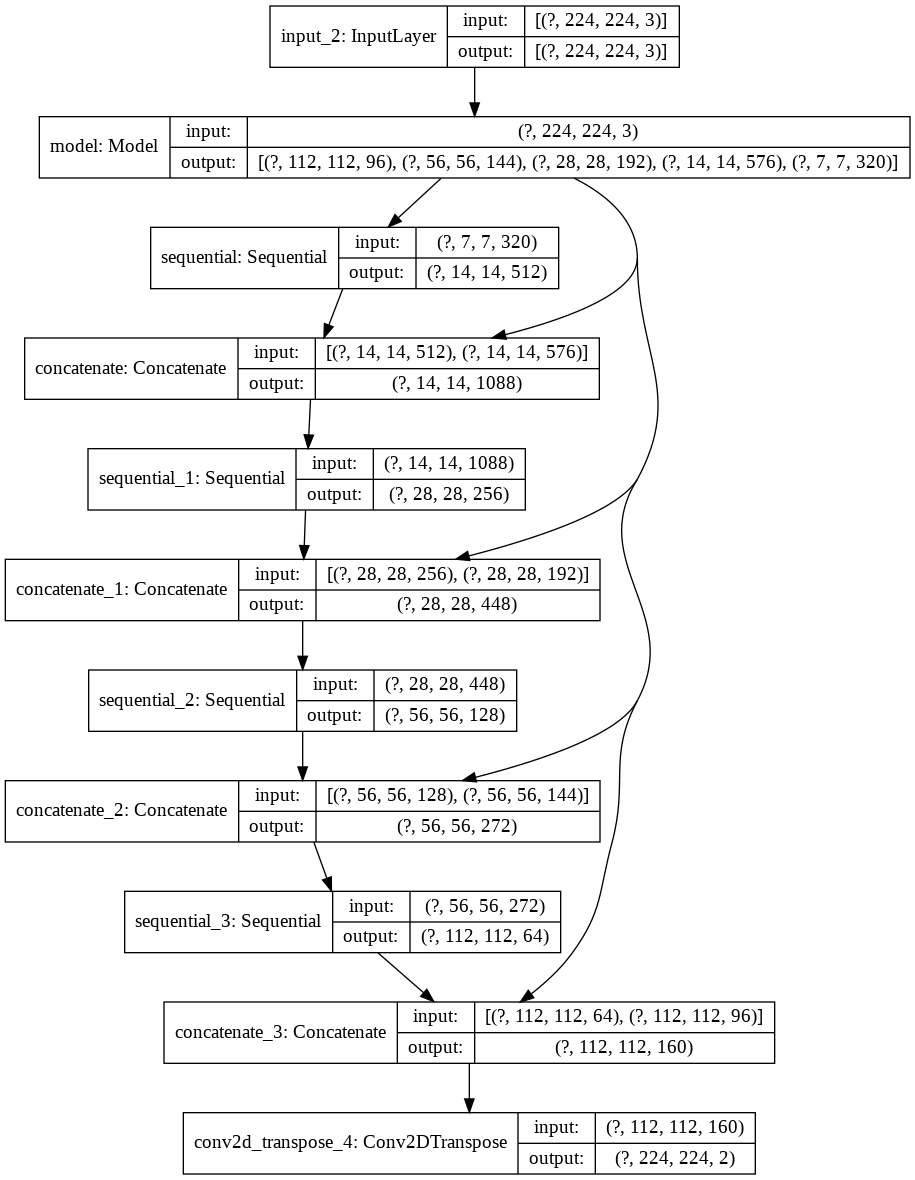

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
# function for displaying the values from show predictions
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# creates an image out of the predicted mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# model predicts mask based on image, displays the image, actual mask, and predicted mask
def show_predictions():
  for n in range(BATCH_SIZE):
    for image, mask in train_ds.take(n):
      pred_mask = model.predict(image)
      accuracy = (pred_mask == mask).numpy().sum() / mask.numpy().size
      if (accuracy - 1 > 0.4):
        display([image[0], mask[0], create_mask(pred_mask)])
        return
    
# optional callback class to display the predicted mask vs. actual mask for each image as the model trains
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 10

tf.keras.backend.clear_session()
results = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch= 3840 // EPOCHS // BATCH_SIZE,
                          validation_steps= 960 // EPOCHS // BATCH_SIZE,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()]) # optional callback

Train for 38 steps, validate for 9 steps
Epoch 1/10
37/38 [============================>.] - ETA: 2s - loss: 0.5610 - accuracy: 0.7218

In [0]:
# Visualization
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()